In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam

from keras.models import model_from_json
from keras.utils.training_utils import multi_gpu_model

from dataset import *
import itertools


In [3]:
from tensorflow.python.client import device_lib
print(keras.__version__)
print(device_lib.list_local_devices())


2.0.9
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17942444580097936080
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 355729408
locality {
  bus_id: 1
}
incarnation: 200314842381896196
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:17.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 355729408
locality {
  bus_id: 1
}
incarnation: 3773727828731387387
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:18.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 355729408
locality {
  bus_id: 1
}
incarnation: 4396736140880381404
physical_device_desc: "device: 2, name: Tesla K80, pci bus id: 0000:00:19.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 357695488
locality {
  bus_id: 1
}
incarnation: 16603126585749387079
physical_device_desc: "device: 3, name: Tesla K80, pci bus id: 0000:00:1a.0"
, name: "/gpu:4"
device_type: "GPU"
memory_limit: 357695488
locality {
  bus_id: 1
}
incarnation: 1807204115

In [4]:
imgs, gt_imgs = training_dataset(limit=100)
print('Image size = ', imgs[0].shape)

Loading 100 training images
Loading 100 groundtruth images
Image size =  (400, 400, 3)


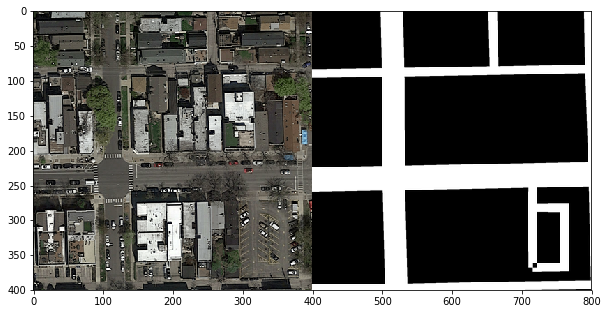

In [5]:
# Show 5th image and its groundtruth image
cimg = concatenate_images(imgs[5], gt_imgs[5])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
patch_size = 16 # each patch is 16*16 pixels

In [7]:
def value_to_class(v, foreground_threshold = 0.25):
    df = np.mean(v)
    return (df > foreground_threshold) * 1

In [8]:
def image_to_patches(img, func):
    p = img.shape
    assert p[0] == p[1]
    n = p[0]
    patches = [
        func(img, i, j)
        for i in range(2*patch_size, n - 3*patch_size+1, patch_size)
        for j in range(2*patch_size, n - 3*patch_size+1, patch_size)
    ]
    return patches

def get_image_crop(img, i, j):
    return img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :]

def get_groundtruth_crop(gt_img, i, j):
    return gt_img[i:i+patch_size, j:j+patch_size]

In [9]:
import random
def gen_random_patches(img, gt, seed=42):
    random.seed(seed)
    n = img.shape[0]
    
    angle = random.choice([0, 90, 180, 270])
    
    
    rot_img = rotate_image(img, [angle])[0]
    rot_gt = rotate_image(gt, [angle])[0]
    
    if random.randrange(2) == 1:
        rot_img = flip_image(rot_img)
        rot_gt = flip_image(rot_gt)
                           
    while True:
        x = random.randrange(n - 80)
        y = random.randrange(n - 80)
        yield (
            rot_img[x:x+80,y:y+80,:],
            rot_gt[x+2*patch_size:x+3*patch_size,
                   y+2*patch_size:y+3*patch_size]
        )

In [11]:
train_data = [
    (patch, gt_patch)
    for i in range(len(imgs))
    for patch, gt_patch in itertools.islice(gen_random_patches(reflect_border(imgs[i], patch_size, 2), reflect_border(gt_imgs[i], patch_size, 2), i), 25*25*8)]

X = np.asarray([img for img, _ in train_data])
y = np.asarray([value_to_class(gt_patch) for _, gt_patch in train_data]).reshape((-1, 1))

print(X.shape)
print(y.shape)

(500000, 80, 80, 3)
(500000, 1)


In [ ]:
def train_test_split(X, y, test_ratio=0.8, seed=42):
    n = len(X)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    limit = int(test_ratio * n)
    X_train, y_train = X[idxs[:limit]], y[idxs[:limit]]
    X_test, y_test = X[idxs[limit:]], y[idxs[limit:]]
    return X_train, X_test, y_train, y_test

In [ ]:
# the data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test  = train_test_split(X, y, 0.8)

In [20]:
# Model parameters
batch_size = 64 *8
num_filters_1 = 16
num_filters_2 = 32
num_filters_3 = 64
num_filters_4 = 128
epochs = 5

In [86]:
model = Sequential()
model.add(Conv2D(num_filters_1, kernel_size=(4, 4), # kernel 5,5 or 4,4
                 #activation='relu',
                 input_shape=input_shape))

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_2, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_3, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_4, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(400, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

simple_model = model

model = multi_gpu_model(model, gpus=8)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3), # 'rmsprop'
              metrics=['accuracy'])



In [87]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_29_input (InputLayer)    (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, 80, 80, 3)    0           conv2d_29_input[0][0]            
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, 80, 80, 3)    0           conv2d_29_input[0][0]            
__________________________________________________________________________________________________
lambda_27 (Lambda)              (None, 80, 80, 3)    0           conv2d_29_input[0][0]            
__________________________________________________________________________________________________
lambda_28 

In [88]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          shuffle=True)
          #validation_data=(x_test, y_test))

Epoch 1/50
500000/500000 [==============================] - 78s 157us/step - loss: 0.3397 - acc: 0.8431
Epoch 2/50
500000/500000 [==============================] - 79s 159us/step - loss: 0.1942 - acc: 0.9201
Epoch 3/50
500000/500000 [==============================] - 78s 155us/step - loss: 0.1604 - acc: 0.9351
Epoch 4/50
500000/500000 [==============================] - 78s 156us/step - loss: 0.1404 - acc: 0.9437
Epoch 5/50
500000/500000 [==============================] - 78s 155us/step - loss: 0.1271 - acc: 0.9498
Epoch 6/50
500000/500000 [==============================] - 78s 155us/step - loss: 0.1191 - acc: 0.9531
Epoch 7/50
500000/500000 [==============================] - 77s 155us/step - loss: 0.1121 - acc: 0.9559
Epoch 8/50
500000/500000 [==============================] - 77s 154us/step - loss: 0.1059 - acc: 0.9583
Epoch 9/50
500000/500000 [==============================] - 77s 155us/step - loss: 0.1022 - acc: 0.9598
Epoch 10/50
500000/500000 [==============================] - 78s

In [89]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[i:i+w, j:j+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [90]:
def print_prediction(img, gt_img, model):
    img_patches = [
        img_patch
        for img_patch in image_to_patches(reflect_border(img, patch_size, 2), get_image_crop)
    ]

    gt_labeled_patches = [
        value_to_class(gt_patch)
        for gt_patch in image_to_patches(reflect_border(gt_img, patch_size, 2), get_groundtruth_crop)
    ]

    predicted_patches = model.predict(np.asarray(img_patches))
    
    w = img.shape[0]
    h = img.shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, predicted_patches)
    
    
    print("Ground truth")
    cimg = concatenate_images(img, gt_img)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Ground truth patches")
    gt_im_patches = label_to_img(w, h, patch_size, patch_size, gt_labeled_patches)

    cimg = concatenate_images(img, gt_im_patches)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Predicted patches")

    cimg = concatenate_images(img, predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Prediction overlay")

    new_img = make_img_overlay(img, predicted_im)

    plt.imshow(new_img)


Ground truth


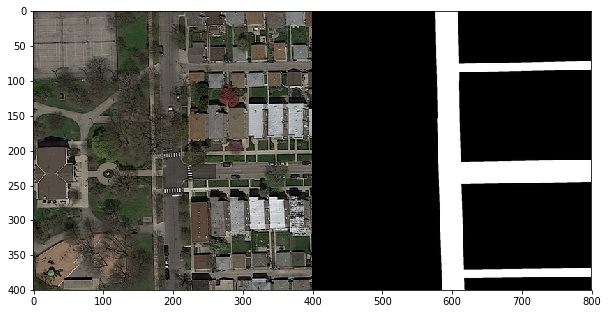

Ground truth patches


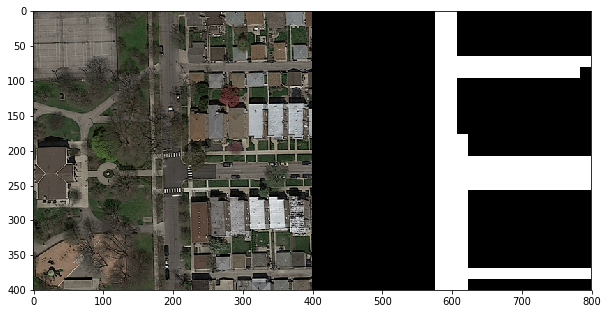

Predicted patches


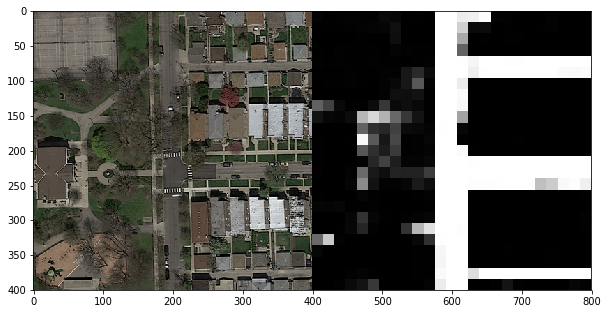

Prediction overlay


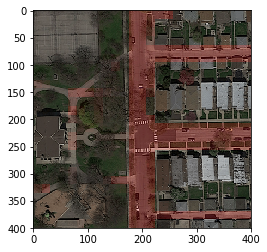

In [91]:
print_prediction(imgs[10], gt_imgs[10], model)

In [ ]:
plt.imshow(predicted_im)


In [92]:
# save the model and the weights to files
model_json = simple_model.to_json()
f = open('savedModels/model_18', 'w')
f.write(model_json)
f.close()

simple_model.save_weights('savedModels/weights_18')